In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Change to VGG16
from sklearn.model_selection import train_test_split

In [2]:
# Set your original image dimensions
original_img_width, original_img_height = 1024, 1024
# Set the desired resized image dimensions
img_width, img_height = 224, 224

# Set the batch size and number of epochs
batch_size = 32
epochs = 30

In [3]:

# Set the path to your CSV file
csv_path = "C:/Users/abida/Desktop/car_damage/datasets/Ai_Or_Not/fake_real_dataset.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [4]:

# Create a data generator with data augmentation and resizing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=lambda x: tf.image.resize(x, (img_width, img_height))
)

# Create a data generator for the training set
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_dataframe(
    val_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Create a data generator for the test set
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1750 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.


In [5]:
# Build the model
model = Sequential()

# Add a pre-trained CNN (e.g., InceptionV3) as a feature extractor
base_model = VGG16(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')  # Change to InceptionV3

#base_model.trainable = False

model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 17926209 (68.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/30
54/54 [==============================] - 2736s 51s/step - loss: 1.1705 - accuracy: 0.5425 - val_loss: 0.6929 - val_accuracy: 0.4688
Epoch 2/30
54/54 [==============================] - 2004s 36s/step - loss: 0.6575 - accuracy: 0.5978 - val_loss: 0.7659 - val_accuracy: 0.5625
Epoch 3/30
54/54 [==============================] - 1831s 34s/step - loss: 0.5143 - accuracy: 0.7439 - val_loss: 0.5608 - val_accuracy: 0.8125
Epoch 4/30
54/54 [==============================] - 2037s 38s/step - loss: 0.4754 - accuracy: 0.7875 - val_loss: 0.2790 - val_accuracy: 0.9375
Epoch 5/30
54/54 [==============================] - 2358s 44s/step - loss: 0.4453 - accuracy: 0.7899 - val_loss: 0.4153 - val_accuracy: 0.9062
Epoch 6/30
54/54 [==============================] - 2457s 45s/step - loss: 0.3966 - accuracy: 0.8295 - val_loss: 0.4536 - val_accuracy: 0.8750
Epoch 7/30
54/54 [==============================] - 2065s 38s/step - loss: 0.3033 - accuracy: 0.8749 - val_loss: 0.4905 - val_accuracy: 0.8750

In [8]:
y_pred_probs = model.predict(test_generator)
threshold = 0.5  # You can adjust this threshold based on your preference

y_pred_labels = (y_pred_probs > threshold).astype(int)

# Display the predicted labels
print("Predicted Labels")

19/19 [==============================] - 236s 12s/step
Predicted Labels


In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Print the evaluation results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

19/19 [==============================] - 224s 12s/step - loss: 0.3347 - accuracy: 0.8701
Test Loss: 0.3347
Test Accuracy: 87.01%


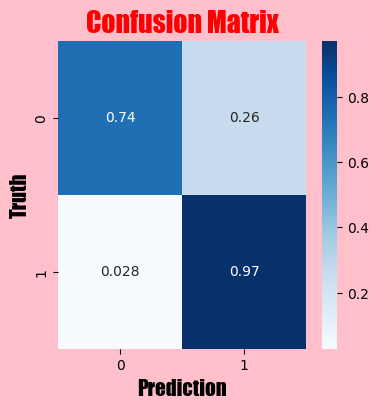

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       255
           1       0.84      0.97      0.90       353

    accuracy                           0.88       608
   macro avg       0.89      0.86      0.87       608
weighted avg       0.89      0.88      0.87       608



In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test and y_pred_labels are your true and predicted labels
y_test = test_generator.classes
cm = confusion_matrix(y_test, y_pred_labels)
cm_percentages = cm / cm.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(4, 4), facecolor='pink', edgecolor='brown')
sn.heatmap(cm_percentages, annot=True, cmap="Blues")

plt.xlabel('Prediction', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.ylabel('Truth', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.title('Confusion Matrix', fontdict={'family': 'fantasy', 'color': 'red', 'size': 20})

plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))


In [10]:
# Save the model
model.save('vgg16.h5') 

c:\Users\abida\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
